<a href="https://colab.research.google.com/github/shsab/DL_Term_Project/blob/main/notebooks/SynthaticDataGeneration_TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Data Generation

In 2020, the amount of data on the internet hit 40 zetabytes. A zetabyte is about a trillion gigabytes. So why we need synthetic data?

There are many good reasons behind it. Here are some important ones:
- Cost of preparing and labeling data
- Prototype Development
- Edge-case Simulation
- Data Privacy

## TimeGAN implementation

- TimeGAN is proposed in 2019.

- It is different from other GAN architecture. It has 4 components:
  - Generator
  - Discriminator
  - Recovery
  - Embedder

- It introduced the concept of supervised loss and embedding network.
  - Supervised loss: The model is capturing the time conditional distribution by using the original data as a supervision.
  - Embedding network: It is reducing the adversarial learning space dimensionality.
It can generate both static (dimensions) and sequential data (TS) at the same time.

- It is less sensitive to hyperparameters.

- The training process is more stable.

### Initialization and imports

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import function

from joblib import dump, load
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

### Utility methods

In [ ]:
def construct_network(model, n_layers, hidden_units, output_units, net_type='GRU'):
    if net_type=='GRU':
        for i in range(n_layers):
            model.add(keras.layers.GRU(units=hidden_units,
                                       return_sequences=True,
                                       name=f'GRU_{i + 1}'))
    else:
        for i in range(n_layers):
            model.add(keras.layers.LSTM(units=hidden_units,
                                        return_sequences=True,
                                        name=f'LSTM_{i + 1}'))

    model.add(keras.layers.Dense(units=output_units,
                                 activation='sigmoid',
                                 name='OUT'))
    return model


def unpack(model, training_config, weights):
    restored_model = keras.layers.deserialize(model)
    if training_config is not None:
        restored_model.compile(**keras.saving.saving_utils.compile_args_from_training_config(training_config))
    restored_model.set_weights(weights)
    return restored_model


def make_keras_picklable():
    def __reduce__(self):
        _metadata = keras.saving.saving_utils.model_metadata(self)
        training_config = _metadata.get("training_config", None)
        model = keras.layers.serialize(self)
        model_weights = self.get_weights()
        return (unpack, (model, training_config, model_weights))

    cls = keras.Model
    cls.__reduce__=__reduce__

### Absolute GAN implementation

In [ ]:
class GanModel():
    def __init__(self, model_parameters):
        gpu_devices = tf.config.list_physical_devices('GPU')
        if len(gpu_devices) > 0:
            try:
                tf.config.experimental.set_memory_growth(gpu_devices[0], True)
            except:
                # Invalid device or cannot modify virtual devices once initialized.
                pass

        self._model_parameters = model_parameters
        [self.batch_size,
         self.lr,
         self.beta_1,
         self.beta_2,
         self.noise_dim,
         self.data_dim,
         self.layers_dim] = model_parameters
        self.define_gan()

    def __call__(self, inputs, **kwargs):
        return self.model(inputs=inputs, **kwargs)

    def define_gan(self):
        raise NotImplementedError

    @property
    def trainable_variables(self, network):
        return network.trainable_variables

    @property
    def model_parameters(self):
        return self._model_parameters

    @property
    def model_name(self):
        return self.__class__.__name__

    def train(self, data, train_arguments):
        raise NotImplementedError

    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in tqdm.trange(steps, desc='Synthetic data generation'):
            z = tf.random.uniform([self.batch_size, self.noise_dim])
            records = tf.make_ndarray(tf.make_tensor_proto(self.generator(z, training=False)))
            data.append(pd.DataFrame(records))
        return pd.concat(data)

    def save(self, path):
        make_keras_picklable()
        try:
            dump(self, path)
        except:
            raise Exception('Please provide a valid path to save the model.')

    @classmethod
    def load(cls, path):
        gpu_devices = tf.config.list_physical_devices('GPU')
        if len(gpu_devices) > 0:
            try:
                tf.config.experimental.set_memory_growth(gpu_devices[0], True)
            except:
                # Invalid device or cannot modify virtual devices once initialized.
                pass
        synth = load(path)
        return synth

### Generator implementation

In [ ]:
class Generator(keras.Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type

    def build(self, input_shape):
        model = keras.Sequential(name='Generator')
        model = construct_network(model,
                                  n_layers=3,
                                  hidden_units=self.hidden_dim,
                                  output_units=self.hidden_dim,
                                  net_type=self.net_type)
        return model

### Discriminator implementation

In [ ]:
class Discriminator(keras.Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type=net_type

    def build(self, input_shape):
        model = keras.Sequential(name='Discriminator')
        model = construct_network(model,
                                  n_layers=3,
                                  hidden_units=self.hidden_dim,
                                  output_units=1,
                                  net_type=self.net_type)
        return model

### Recovery implementation

In [ ]:
class Recovery(keras.Model):
    def __init__(self, hidden_dim, n_seq):
        self.hidden_dim=hidden_dim
        self.n_seq=n_seq
        return

    def build(self, input_shape):
        recovery = keras.Sequential(name='Recovery')
        recovery = construct_network(recovery,
                                     n_layers=3,
                                     hidden_units=self.hidden_dim,
                                     output_units=self.n_seq)
        return recovery

### Embedder implementation

In [ ]:
class Embedder(keras.Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim
        return

    def build(self, input_shape):
        embedder = keras.Sequential(name='Embedder')
        embedder = construct_network(embedder,
                                     n_layers=3,
                                     hidden_units=self.hidden_dim,
                                     output_units=self.hidden_dim)
        return embedder

### Supervisor implementation

In [ ]:
class Supervisor(keras.Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim

    def build(self, input_shape):
        model = keras.Sequential(name='Supervisor')
        model = construct_network(model,
                                  n_layers=2,
                                  hidden_units=self.hidden_dim,
                                  output_units=self.hidden_dim)
        return model

### TimeGAN implementation

In [ ]:
class TimeGAN(GanModel):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        self.seq_len=seq_len
        self.n_seq=n_seq
        self.hidden_dim=hidden_dim
        self.gamma=gamma
        super().__init__(model_parameters)

    def define_gan(self):
        self.generator_aux=Generator(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))
        self.supervisor=Supervisor(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.discriminator=Discriminator(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.embedder = Embedder(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))

        X = keras.Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RealData')
        Z = keras.Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RandomNoise')

        # Building the AutoEncoder
        H = self.embedder(X)
        X_tilde = self.recovery(H)

        self.autoencoder = keras.Model(inputs=X, outputs=X_tilde)

        # Adversarial Supervise Architecture
        E_Hat = self.generator_aux(Z)
        H_hat = self.supervisor(E_Hat)
        Y_fake = self.discriminator(H_hat)

        self.adversarial_supervised = keras.Model(inputs=Z,
                                       outputs=Y_fake,
                                       name='AdversarialSupervised')

        # Adversarial architecture in latent space
        Y_fake_e = self.discriminator(E_Hat)

        self.adversarial_embedded = keras.Model(inputs=Z,
                                    outputs=Y_fake_e,
                                    name='AdversarialEmbedded')
        # Synthetic data generation
        X_hat = self.recovery(H_hat)
        self.generator = keras.Model(inputs=Z,
                            outputs=X_hat,
                            name='FinalGenerator')

        # Final discriminator model
        Y_real = self.discriminator(H)
        self.discriminator_model = keras.Model(inputs=X,
                                         outputs=Y_real,
                                         name="RealDiscriminator")

        # Define the loss functions
        self._mse=keras.losses.MeanSquaredError()
        self._bce=keras.losses.BinaryCrossentropy()


    @function
    def train_autoencoder(self, x, opt):
        with tf.GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return tf.sqrt(embedding_loss_t0)

    @function
    def train_supervisor(self, x, opt):
        with tf.GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            g_loss_s = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s

    @function
    def train_embedder(self,x, opt):
        with tf.GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return tf.sqrt(embedding_loss_t0)

    def discriminator_loss(self, x, z):
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=tf.ones_like(y_real),
                                            y_pred=y_real)

        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=tf.zeros_like(y_fake),
                                            y_pred=y_fake)

        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=tf.zeros_like(y_fake_e),
                                              y_pred=y_fake_e)
        return (discriminator_loss_real +
                discriminator_loss_fake +
                self.gamma * discriminator_loss_fake_e)

    @staticmethod
    def calc_generator_moments_loss(y_true, y_pred):
        y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
        y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
        g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
        g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
        return g_loss_mean + g_loss_var

    @function
    def train_generator(self, x, z, opt):
        with tf.GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=tf.ones_like(y_fake),
                                                    y_pred=y_fake)

            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=tf.ones_like(y_fake_e),
                                                      y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * tf.sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)

        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

    @function
    def train_discriminator(self, x, z, opt):
        with tf.GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)

        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss

    def get_batch_data(self, data, n_windows):
        data = tf.convert_to_tensor(data, dtype=tf.float32)
        return iter(tf.data.Dataset.from_tensor_slices(data)
                                .shuffle(buffer_size=n_windows)
                                .batch(self.batch_size).repeat())

    def _generate_noise(self):
        while True:
            yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))

    def get_batch_noise(self):
        return iter(tf.data.Dataset.from_generator(self._generate_noise, output_types=tf.float32)
                                .batch(self.batch_size)
                                .repeat())

    def train(self, data, train_steps):
        ## Embedding network training
        autoencoder_opt = keras.optimizers.Adam(learning_rate=self.lr)
        for _ in tqdm(range(train_steps), desc='Emddeding network training'):
            X_ = next(self.get_batch_data(data, n_windows=len(data)))
            step_e_loss_t0 = self.train_autoencoder(X_, autoencoder_opt)

        ## Supervised Network training
        supervisor_opt = keras.optimizers.Adam(learning_rate=self.lr)
        for _ in tqdm(range(train_steps), desc='Supervised network training'):
            X_ = next(self.get_batch_data(data, n_windows=len(data)))
            step_g_loss_s = self.train_supervisor(X_, supervisor_opt)

        ## Joint training
        generator_opt = keras.optimizers.Adam(learning_rate=self.lr)
        embedder_opt = keras.optimizers.Adam(learning_rate=self.lr)
        discriminator_opt = keras.optimizers.Adam(learning_rate=self.lr)

        step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
        for _ in tqdm(range(train_steps), desc='Joint networks training'):

            #Train the generator (k times as often as the discriminator)
            # Here k=2
            for _ in range(2):
                X_ = next(self.get_batch_data(data, n_windows=len(data)))
                Z_ = next(self.get_batch_noise())

                # Train the generator
                step_g_loss_u, step_g_loss_s, step_g_loss_v = self.train_generator(X_, Z_, generator_opt)

                # Train the embedder
                step_e_loss_t0 = self.train_embedder(X_, embedder_opt)

            X_ = next(self.get_batch_data(data, n_windows=len(data)))
            Z_ = next(self.get_batch_noise())
            step_d_loss = self.discriminator_loss(X_, Z_)
            if step_d_loss > 0.15:
                step_d_loss = self.train_discriminator(X_, Z_, discriminator_opt)

    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))


## Experiment
The data is the googles stock downloaded from Yahoo Finance.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import requests as req
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from google.colab import files
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm
from tqdm.keras import TqdmCallback

### Utility functions

Data is fetched from [Yahoo Finance](https://finance.yahoo.com/quote/AMZN/history?period1=1420070400&period2=1626739200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) and saved and shared in my Google Drive. I have data for Google, Amazon, and Apple stock.

In [ ]:
def real_data_loading(data: np.array, seq_len):
    # Flip the data to make chronological data
    ori_data = data[::-1]
    # Normalize the data
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)

    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data

def get_data(seq_len: int, stock_symbol='AMZN'):
    file_path = os.path.join('/resources', 'data', f'{stock_symbol}.csv')
    print(file_path)
    try:
        stock_df = pd.read_csv(file_path)
    except:
        if stock_symbol == 'GOOG':
          stock_url = 'https://drive.google.com/u/0/uc?id=1psnECSivl3euQkL7SdX-ak6MI-SxVK8d&export=download'
        elif stock_symbol == 'AMZN':
          stock_url = 'https://drive.google.com/file/d/1SGOoKllIoT1kV97XegOz6vLPrLCO7eSa/view?usp=sharing'
        elif stock_symbol == 'AAPL':
          stock_url = 'https://drive.google.com/file/d/1k_b21HDfhdxeEyiSJ9Jp-CEYq2dNmOnV/view?usp=sharing'          
        else:
          raise Exception('Valid values for stock_symbol is GOOG and AMZN!')

        request = req.get(stock_url)
        url_content = request.content

        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
        stock_csv = open(file_path, "wb")
        stock_csv.write(url_content)
        # Reading the stock data
        stock_df = pd.read_csv(file_path)
        print(stock_df.shape)
    try:
        stock_df = stock_df.set_index('Date').sort_index()
    except:
        stock_df=stock_df
    #Data transformations to be applied prior to be used with the synthesizer model
    processed_data = real_data_loading(stock_df.values, seq_len=seq_len)

    return processed_data, stock_df

### Data Preparation

In [ ]:
seq_len = 24
n_seq = 6
hidden_dim = 24
gamma = 1
noise_dim = 32
dim = 128
batch_size = 128
log_step = 100
learning_rate = 5e-4
gan_args = [batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim]

stock_data, stock_df = get_data(seq_len=seq_len, stock_symbol='GOOG')
print(len(stock_data), stock_data[0].shape)

/resources/data/GOOG.csv
(1647, 7)
1623 (24, 6)


### Train

There are three training phases:

- **Phase I**: Training the Autoencoder
- **Phase II**: Training the supervisor to capture the temporal behavior.
- **Phase III**: The combined training of generator, discriminator and embedder. We try to minimize all three loss functions in this phase. Based on the papers suggestion the generator and embedder are trained twice the discriminator in this phase.

With respect to the loss functions:

- **Reconstruction loss**: Compares the reconstruction of the encoded data compared to the original data.
- **Supervised loss**: Measures the quality of generator approximation of the next time step in the latent space.
- **Unsupervised loss**: This is the familiar min-max game. It shows the relation of the generator and discriminator networks.

In [ ]:
if os.path.exists(os.path.join('/resources', 'model', 'synthesizer_stock.pkl')):
    synthysizer = TimeGAN.load(os.path.join('/resources', 'model', 'synthesizer_stock.pkl'))
else:
    synthysizer = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synthysizer.train(stock_data, train_steps=20000)

Joint networks training: 100%|██████████| 20000/20000 [3:28:20<00:00,  1.60it/s]


### Generate Synthetic data

In [ ]:
synthetic_data = synthysizer.sample(len(stock_data))
print(synthetic_data.shape)

Synthetic data generation: 100%|██████████| 13/13 [00:01<00:00,  9.81it/s]

(1664, 24, 6)


### Plot to compare generated samples with real data

In [ ]:
!mkdir /resources/graphs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

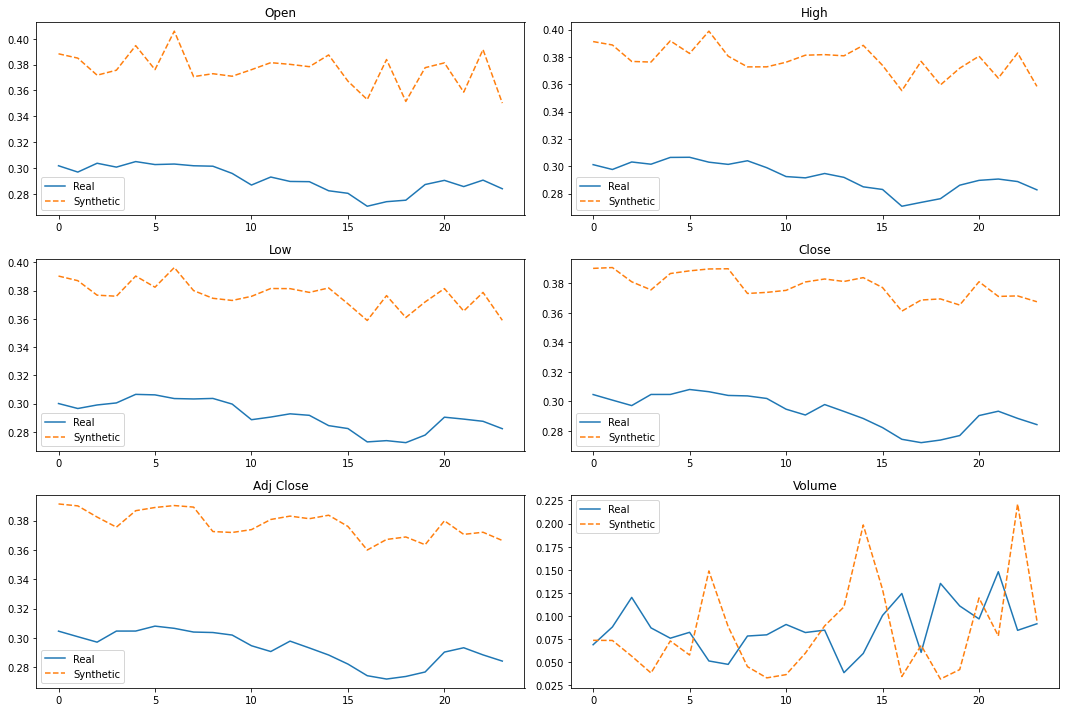

In [ ]:
# Reshaping the data
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()

time = list(range(1, 25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                        'Synthetic': synthetic_data[obs][:, j]})
    df.plot(ax=axes[j],
            title=col,
            secondary_y='Synthetic data', style=['-', '--'])

    try:
        df.to_csv(os.path.join('/resources', 'data', f'synthesized_stock_df_{col}.csv'))
    except Exception as Err:
        print('Saving synthesized_stock failed!', str(Err))
        pass
fig.tight_layout()
plt.savefig(os.path.join('/resources', 'graphs', 'data_comparison.png'))
files.download(os.path.join('/resources', 'graphs', 'data_comparison.png')) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

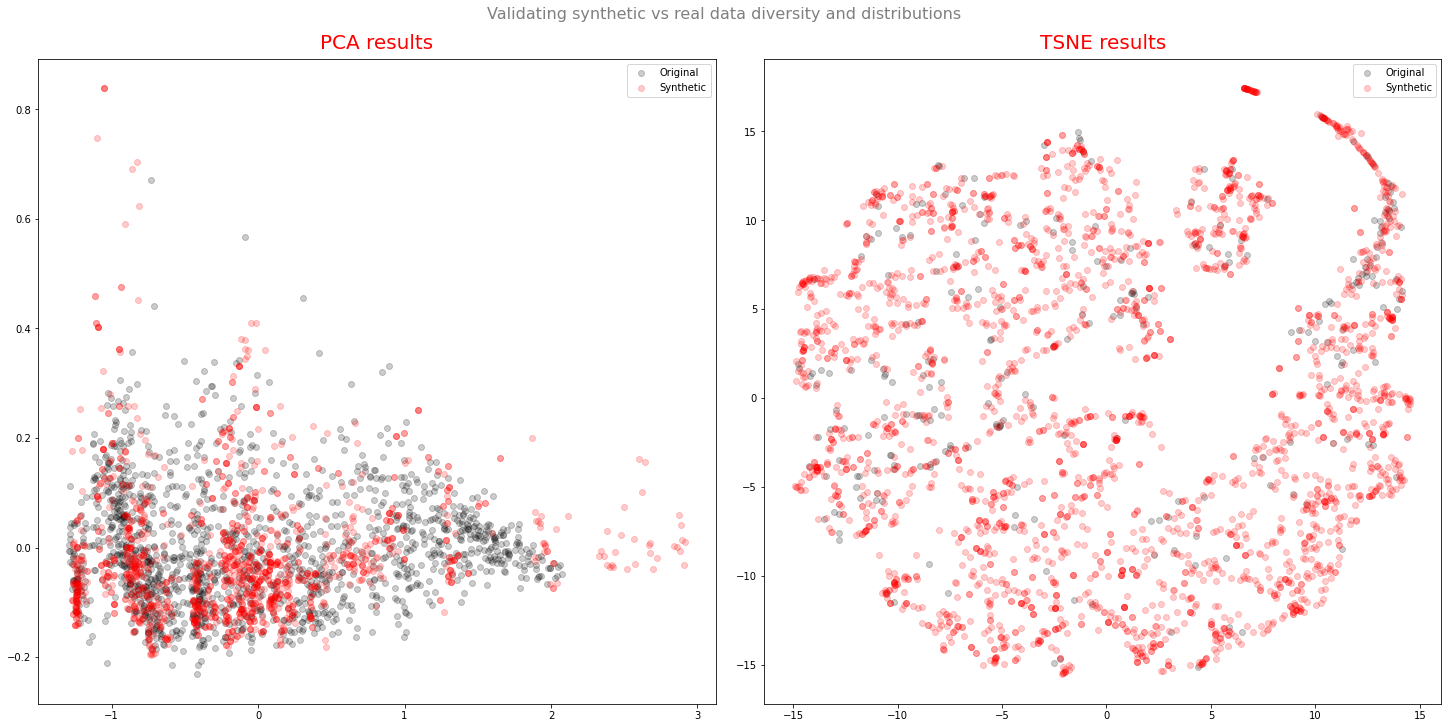

In [ ]:
sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

# We use only two componentes for both the PCA and TSNE for comparision in 2-Dimensional space.
reduced_synth_data = real_sample.reshape(-1, seq_len)
reduced_stock_data = np.asarray(synthetic_sample).reshape(-1, seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

# The fit of the methods must be done only using the real sequential data
pca.fit(reduced_stock_data)

pca_real = pd.DataFrame(pca.transform(reduced_stock_data))
pca_synth = pd.DataFrame(pca.transform(reduced_synth_data))

reduced_data = np.concatenate((reduced_stock_data, reduced_synth_data), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(reduced_data))

# The scatter plots for PCA and TSNE methods
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# TSNE scatter plot
ax = fig.add_subplot(spec[0, 0])
ax.set_title('PCA results',
              fontsize=20,
              color='red',
              pad=10)

# PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:, 0], pca_synth.iloc[:, 1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0, 1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size, 1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:, 0], tsne_results.iloc[sample_size:, 1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
              fontsize=16,
              color='grey')

# fig.tight_layout()
plt.savefig(os.path.join('/resources', 'graphs', 'synthetic_vs_real.png'))
files.download(os.path.join('/resources', 'graphs', 'synthetic_vs_real.png')) 

### Train a model on Synthetic data and test on real data

In [ ]:
def simple_RNN_regressor(units):
    opt = keras.optimizers.Adam(name='AdamOpt')
    loss = keras.losses.MeanAbsoluteError(name='MAE')
    model = keras.Sequential()
    model.add(keras.layers.GRU(units=units,
                  name=f'RNN_1'))
    model.add(keras.layers.Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [ ]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
synth_data = synthetic_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (1217, 23, 6)
Real X train: (1217, 23, 6)
Synthetic y train: (1217, 6)
Real y train: (1217, 6)
Real X test: (406, 23, 6)
Real y test: (406, 6)


#### Train on real data and test on real data 

---



In [ ]:
#Training the model with the real train data
ts_real = simple_RNN_regressor(12)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          verbose=0,
                          callbacks=[TqdmCallback(verbose=1)])

#### Train on Synthetic data test on real data

In [ ]:
#Training the model with the synthetic data
ts_synth = simple_RNN_regressor(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          verbose=0,
                          callbacks=[TqdmCallback(verbose=1)])

#### Summeries metrics in a dataframe 

In [ ]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE
Real,0.835077,0.013709,0.000803
Synthetic,0.831733,0.018842,0.000899


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

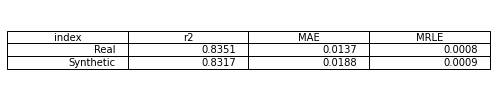

In [ ]:
plt.rcParams["figure.figsize"] = [7.00, 1.50]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
axs.axis('tight')
axs.axis('off')
the_table = axs.table(cellText=results.apply(lambda x: round(x, 4)).reset_index().values, 
                      colLabels=list(results.reset_index().columns), 
                      loc='center')
# fig.tight_layout()
plt.savefig(os.path.join('/resources', 'graphs', 'train_synth_test_real.png'))
files.download(os.path.join('/resources', 'graphs', 'train_synth_test_real.png')) 
plt.show()

In [ ]:
files.download(os.path.join('/resources', 'graphs', 'data_comparison.png')) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>